# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }

plt.rcParams.update(params)

import pandas as pd
from pandas import json_normalize

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

import re
import copy
import os
import sys
import json
from datetime import datetime
from collections import Counter
import string
import glob
import ast
from tqdm.notebook import tqdm
import xmltodict

from tabulate import tabulate


TITLE_SIZE = 24
TITLE_PAD = 20

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Data acquisition
---

In a first step I **focus on podcasts listed on Apple iTunes in German language.** 

Available data sources:
- [Top Podcast API](https://rss.applemarketingtools.com/) from Apple Marketing Tools. Yields 200 results max. Unfortunately, the endpoint cannot be queried for specific genres.
- [iTunes Top Audio Podcast API](https://itunes.apple.com/de/rss/topaudiopodcasts/limit=100/explicit=true/json). Yields 100 results max, can be queried for genres. Note: The «top» podcasts listed here aren't consistent with the actual Apple podcast charts shown in Apple's podcast app and on chart sites like [Chartable](https://chartable.com). Some of the entries are outdated, e.g., podcast «Gemischtes Hack» which has become a Spotify exclusive in September 2019. 
- [iTunes search API](https://developer.apple.com/library/archive/documentation/AudioVideo/Conceptual/iTuneSearchAPI/index.html#//apple_ref/doc/uid/TP40017632-CH3-SW1) and [iTunes lookup API](https://developer.apple.com/library/archive/documentation/AudioVideo/Conceptual/iTuneSearchAPI/LookupExamples.html#//apple_ref/doc/uid/TP40017632-CH7-SW1). Both endpoints provide clean metadata and can be queried either with lists of known podcast IDs or search terms. The search API seems frickle and is rate limited to at best 20 calls per minutes (apparently way less). 
- Third party data providers like [Chartable](https://chartable.com) or [Listen Notes](https://www.listennotes.com/).
- RSS feeds of the podcast creators. Once I have the RSS feed URL I can request and parse more detailed metadata from this, especially for all available episodes.

My data acquisition procedure:

- [x] Get iTunes genre names and genre IDs
- [x] Get data for top podcasts in all genres
- [x] Acquire data from third party sources
- [x] Get data for long tail podcasts
- [x] Clean and concatenate results to one dataframe
- [x] Query RSS feeds for podcast metadata (contains language tag)
- [x] Reduce to German language podcasts and deduplicate (results in 7.6k unique podcasts)
- [x] Query RSS feeds for episode metadata (492k episodes available) 
- [x] Aggregate episode metadata to podcast level
- [x] Merge aggregated episode data with podcast data frame

**The result of my data acquisition notebook is a cleaned dataframe of 7'610 podcasts and their 462k available episodes with aggregated and detailed information like summaries, contents, tags.**

<span style="color:darkred">*Note: The code for the data acquisition and preparation steps are omitted here.*</span>

…

# EDA of the podcast data set
---

During data acquisition I assembled a set of metadata of 7.6k podcasts and their related episodes. Now I look into the gathered data and try to assess the options for improving search and discovery more precisely.

In [2]:
df = pd.read_parquet("_data/podcasts_cleaned.parq")
df.releaseDate = pd.to_datetime(df.releaseDate)

In [3]:
display(df.info(memory_usage="deep"))
print()
print(f"There are {len(df) :,.0f} observations and {len(df.columns)} features in total.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7610 entries, 0 to 7609
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   trackId            7610 non-null   int64              
 1   artistName         7574 non-null   object             
 2   ep_authors         6666 non-null   object             
 3   title              7610 non-null   object             
 4   ep_titles          7610 non-null   object             
 5   ep_itunes_titles   3953 non-null   object             
 6   subtitle           6049 non-null   object             
 7   ep_subtitles       4389 non-null   object             
 8   summary            6544 non-null   object             
 9   ep_summaries       7243 non-null   object             
 10  ep_contents        6881 non-null   object             
 11  tags               7541 non-null   object             
 12  ep_tags            3680 non-null   object       

None


There are 7,610 observations and 29 features in total.


## Feature documentation

The dataset contains these features:
- `trackId` – iTunes identifier for podcasts
- `artistName` – iTunes artist name
- `ep_authors` – all authors provided in RSS feed of episodes
- `title` – iTunes podcast title
- `ep_titles` – all episodes titles provided in RSS feed
- `ep_itunes_titles` – all episode titles for iTunes provided in RSS feed
- `subtitle`- iTunes podcast subtitle
- `ep_subtitles` – all episode subtitles for iTunes provided in RSS feed
- `summary` - iTunes podcast summary
- `ep_summaries` – all episode summaries provided in RSS feed
- `ep_contents` – all episode content information provided in RSS feed
- `tags` – iTunes general tags for the podcast
- `ep_tags` – all episode tags provided in RSS feed
- `primary_genre` – iTunes primary genre for the podcast
- `genres` – all iTunes genres for the podcast
- `toplist_top_genre` – genre by which the podcast was listed in iTunes top lists
- `toplist_sub_genre` – subgenre by which the podcast was listed in iTunes top lists
- `chartable_genre` – genre by which the podcast was listed in the Chartable charts
- `genreIds` – iTunes genre identifier for the podcast
- `toplist_genre_id` – genre identifier by which the podcast was listed in iTunes top list
- `generator` - platform that was used to publish the podcast, e.g. Podigee, Anchor etc.
- `itunes_type` – type of podcast, either `episodic` or `serial`
- `explicit` – contains `True` if podcast contains explicit content
- `releaseDate` – latest update of podcast
- `trackCount` – count of available episodes in RSS feed
- `feedUrl` – RSS feed URL
- `artworkUrl600` – link to artwork / preview image
- `from_chartable` – listed on Chartable?
- `not_longtail` – contains `True` if podcast is from top lists or charts

## Missing values

- **Data is missing for several features**. 
- Some of this is expected, e.g., only around 15% of the podcasts were listed on Chartable. 
- Missing values for episode tags (`ep_tags`) and podcast `summary` are unfortunate since I assume that these are salient features.

In [4]:
missing = [(c, df[c].isna().mean()*100) for c in df]
missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
missing = missing[missing.percentage > 0]
print("Percentage of missing values")
print(tabulate(missing.sort_values("percentage", ascending=False), floatfmt=".1f", showindex=False))

Percentage of missing values
-----------------  ----
chartable_genre    85.6
toplist_sub_genre  70.5
toplist_top_genre  54.6
toplist_genre_id   54.6
ep_tags            51.6
ep_itunes_titles   48.1
ep_subtitles       42.3
itunes_type        23.4
subtitle           20.5
generator          17.3
summary            14.0
ep_authors         12.4
ep_contents         9.6
ep_summaries        4.8
tags                0.9
artistName          0.5
-----------------  ----


0.5% of samples do not have an `artistName`. In most cases this seems somewhat comprehensible, e.g., for podcasts of sermons.

In [5]:
display(df[df.artistName.isna()][["artistName", "title", "subtitle"]])

,artistName,title,subtitle
48,None,spanisch-live.de - Podcast,"spanisch-live.de: Sprachreisen, Spanischkurse ..."
49,None,Predigten des Christus-Treff-Marburg,None
100,None,Andreas Bolli www.andreas-bolli.ch,Andreas Bolli ist nicht nur Coach sondern hat ...
135,None,Vorträge von der Website Ganglion.ch,Vorträge von Frau Dr. med. Ursula Davatz
157,None,Latizón TV - el corazón de Latinoamerica,"Interviews, Informationen und Berichte, sowie ..."
180,None,No Title,None
199,None,No Title,None
254,None,RadioAktiv - Das Campusradio der FH Kiel (RSS),None
284,None,freie-radios.net - aktuelle Beitraege,Die neuesten Beitraege im Audio-Portal der deu...
325,None,Treffpunkt Leben Gemeinde Erkrath,www.treffpunkt-leben.com


Some podcasts do not have a title. I decide to remove these few samples.

In [6]:
display(df[df.title.str.contains("no title", case=False)][["artistName", "title", "subtitle"]])

,artistName,title,subtitle
173,Golfspot.de,No Title,Golfspot Leading Golf Destinations
180,None,No Title,None
199,None,No Title,None
211,Miniatur Wunderland Hamburg,No Title,Miniatur Wunderland Audio Podcast
214,Miniatur Wunderland Hamburg,No Title,Miniatur Wunderland Video Podcast
515,None,No Title,Berni und Ert
575,"Fizzl, Jacob Risp, Mario Maser und MichiL.",No Title,BAMBEATS - Ein RAUSCH.KOLLEKTIV Podcast für el...
2152,©2021 meinsportpodcast.de,No Title,None


In [7]:
to_drop = df[df.title.str.contains("no title", case=False)].index
df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)

## Examining the features one by one
I now will examine every feature one by one (or in sensible groupings).

### Observations from `artistName`

- **Several publishers have a large collection of unique podcasts in the retrieved data**. E.g., public service media like WDR, BR, NDR, SRF etc.
- WDR has the most podcasts in the data (103).
- **The mean/median of unique podcasts per publisher in this data set is around 1**. 

In [8]:
display(df.artistName.value_counts()[:20])

Westdeutscher Rundfunk                               103
Friedrich-Alexander-Universität Erlangen-Nürnberg     69
Bayerischer Rundfunk                                  54
NDR Info                                              39
DW.COM | Deutsche Welle                               26
Deutschlandfunk                                       24
Prof. Dr. Christoph Meinel                            21
ZEIT ONLINE                                           20
Schweizer Radio und Fernsehen (SRF)                   20
Rocket Beans TV                                       19
Mitteldeutscher Rundfunk                              18
hr-iNFO                                               18
Prof. Dr. Hans Kudlich                                17
ZDFde                                                 16
Prof. Dr. Andreas Polze                               16
radio horeb                                           15
NDR Kultur                                            14
Prof. Dr. Kai Willner          

In [9]:
print("Statistics about unique podcasts per author")
print(np.round(df.artistName.value_counts().describe(), decimals=2))

Statistics about unique podcasts per author
count    6358.00
mean        1.19
std         2.05
min         1.00
25%         1.00
50%         1.00
75%         1.00
max       103.00
Name: artistName, dtype: float64


**The information provided in this feature** `authorName` **is diverse.** Most of it is quite generic. Some of it is salient and contains key words related to the content.

In [10]:
print(df.sample(20).artistName.values)

['Severin Hoensbroech'
 'SharePoint Rhein-Ruhr / Andrej Doms & Henning Eiben' 'Moritz Matzke'
 'Sina Wollgramm & Silke Wildner | Podcastfabrik Bielefeld'
 'Westdeutscher Rundfunk' 'Noble Heritage' 'The King & The Duck'
 'Bernhard Hiergeist' '©2021 meinsportpodcast.de' 'hr-info' 'Luis Pazos'
 'Kassenärztliche Bundesvereinigung' 'Stuttgarter Nachrichten & Antenne 1'
 'Erfolgreiche Unternehmer in inspirierenden Beiträgen und Interviews. Erfol'
 'Nuria Pape - Ernährungsberaterin und Achtsamkeits-Coach'
 'Kathrin Ismaier - Gesundheitspraktikerin für bewusste Sexualität & Selbstliebe Coach'
 'Maik Bruns/Metrika' 'funk – von ARD und ZDF' 'considercologne'
 'Torsten Jasper und Nicolas Vogt']


### Observations from `ep_authors`

- **Here too we have a wide mix of generic and salient terms and people's and organisation's names.** 
- A proper extraction of persons names will be hard – these are given in various formattings, e.g. first name before or after last name or just first or just last name.

In [11]:
display(df.ep_authors.apply(lambda x: " ".join(x) if x is not None else x).value_counts())

DW.COM | Deutsche Welle                          26
Schweizer Radio und Fernsehen (SRF)              20
Rocket Beans TV                                  19
Mitteldeutscher Rundfunk                         18
ZDFde                                            16
                                                 ..
Katja Jäger Katja Jäger - Die Erfolgsmacherin     1
Kati Siemens                                      1
Hertha BSC                                        1
Markus Wessel                                     1
Thomas Sachsenmaier & Simon Ihlenfeldt            1
Name: ep_authors, Length: 6236, dtype: int64

In [12]:
print(df.sample(10).ep_authors.values)

[array(['Samu'], dtype=object)
 array(['MIND TRAINING VELKE', 'Roland Velke',
        'Roland Velke | MIND TRAINING VELKE'], dtype=object)
 array(['Klaus Treder'], dtype=object)
 array(["Men's Health Deutschland"], dtype=object)
 array(['Nina & Frank von OPITZ CONSULTING'], dtype=object)
 array(['Die Clubberer'], dtype=object)
 array(['Steffie Mannheim & Kai Klüting',
        'Steffie Mannheim und Kai Klüting'], dtype=object)
 array(['Timo Landsiedel'], dtype=object)
 array(['Rebecca Lina'], dtype=object)
 array(['Sabrina Heinke'], dtype=object)]


### Observations from title and subtitle features

- **The title features contain many salient key words and entities related to the podcast's content and genre.**
- **Episode titles and subtitles will provide an even wider range of information and entities.**
- **The textual content isn't clean, particularly not the subtitles. I notice HTML tags, control characters, line breaks etc.**
- Some of the texts **contain promotional information for the podcast or from sponsors** («Erhalte 10% Rabatt mit Code ABC bei unserem Sponsor XYZ»). **This can bring in topics that aren't related to the actual podcast content and will be hard to discern.**

In [36]:
display(df.sample(10).title.values)
print()
display(df.sample(10).subtitle.values)

array(['Mama Lauda', 'Sing oder Stirb! - Vocalcoaching to go',
       'Schwarmtaler', 'Kanal Schnellroda', 'Slow German', 'Der CineCast',
       'LISTEN2', 'SEM fm - Science, Entertainment & Marketing',
       'Kack & Sachgeschichten',
       'New Work Stories - Der Podcast zur Zukunft der Arbeitswelt'],
      dtype=object)

array(['Die Stammtischphilosophen sind zurück', None,
       'Dein Podcast zur Orientierung im Alltag und Beruf', None,
       'Mit Mut fängt Geschichte an - und definitiv die Geschichten, die ihr bei Be Bold Radio auf die Ohren bekommt.  Lasst Euch von wagemutigen Menschen inspirieren, die sich im Leben etwas trauen und dabei Widerstände überwinden - seien es eigene Ängste oder äußere Umstände.  Stay tuned!  Euer Be Bold Radio Team Tommi, Janina, Radha und Jörn',
       None,
       'Der Podcast von Kreativen für Kreative. In "Ich Bin Kreativ Und Du?" oder auch "IBKUD" geht es um interessante Menschen mit kreativen Fähigkeiten. Ob jemand damit sein Geld verdient oder doch eher in der Freizeit kreativ unterwegs ist, ist egal. Es geht um tolle Geschichten, interessantes Know-How, das richtige Mindest, geile Background Stories, Kreativtechniken und vieles mehr. \n\nIn einer Interviewform werde ich von Fotografen, Grafikdesignern, Tänzern, Hobbyschriftstellern und vielen mehr die besten G

In [14]:
display(df.sample(1).ep_titles.values[0][:3])
print()
display(df.dropna(subset=["ep_itunes_titles"]).sample(1).ep_itunes_titles.values[0][:3])
print()
display(df.sample(1).ep_subtitles.values[0][:3])
print()

array(['Golf Mental: Sicher Putten',
       'Golf Mental: So vermeiden Sie negatives Denken',
       'Golf Mental: Umgang mit Fehlern und Rückschlägen'], dtype=object)

array(['Böker Plus Epicenter - Jahresmesser 2021',
       'Daniel von dp_steelandleather im Interview',
       'Das AK1 - mit Alex und Jannik'], dtype=object)

array(['Angesichts von COVID-19, der Arbeitslosigkeit, der Abwesenheit staatlicher Hilfen und des rechtsextremen Präsidenten bleibt Gemeinschaften am Rio Negro nur die Unterstützung der Copime.',
       'Die Rechte von Frauen und Dissident*innen auf der ganzen Welt wurden durch die Pandemie beeinträchtigt, da die geschlechtsspezifische Gewalt und Fälle von Femiziden zunahmen.',
       'El Salvador: Roman über die Feministin Prudencia Ayala - Brasilien: Jugendliche sauer über spaßbefreites Leben und die untätige Regierung - Hinhörer Gesundheit'],
      dtype=object)

### Observations from summary and content features

- **From podcast and episode summaries and `ep_contents` we get more valuable information that likely will prove useful downstream.**
- **The texts contain HTML tags, links, email-addresses, social media handles, hashtags, emojis, line breaks and various other control characters**, that likely need to be filtered out or cleaned.
- **Like in the subtitles, the summaries and content texts sometimes entail sponsor messages and promotional content.**

In [22]:
display(df.sample(5).summary.values)
print()
display(df.dropna(subset=["ep_contents"]).sample(5).ep_summaries.values[0][:2])
print()
display(df.dropna(subset=["ep_contents"]).sample(5).ep_contents.values[0][:2])
print()

array(['Spannungen, Formänderungen, Stoffgesetz (kleine Deformationen, isotropes und homogenes Material)\n Spannungen und Verformungen gerader, schlanker Träger unter Zug, Biegung, Torsion und Querkraftschub\n Energiemethoden - Verfahren von Mohr, Satz von Castigliano\n Elastische Stabilität - Knicken von Stäben\n Einführung in die Elastizitätstheorie (mehrachsige Spannungszustände, Spannungstransformation, spezifische Dehnungs- und Gestaltänderungsenergie)\n Festigkeitsnachweis (Materialprüfung, Festigkeitshypothesen, Wirkung von Kerben und Rissen)',
       'Die Zusammenarbeit zwischen Unternehmern und Kreativen ist nicht immer einfach. Dieser Podcast soll mit Best-Practices, Tipps & Case-Studies helfen, diese Zusammenarbeit zu verbessern, damit sowohl Kreative als auch Unternehmen davon profitieren können. Als ehemaliger Projektmanager für Software-Entwicklung und als Fotograf & Filmer bringe ich Erfahrung und Know-How mit, das DIR helfen kann. Egal ob du Unternehmer bist oder Kreati

array(['<p>2G, 3G, Doppel-D, Freedom-Day, mit Test oder ohne? Mit welchem Regelwerk wird Köln den 11.11. feiern? Am selbstgebastelten Bierkastentresen ist Wirt und IG Gastro-Vorstand Daniel Rabe mit wenig erfreulichen Einschätzungen zu Gast. Mit Stefan Knittler und Helmut Frangenberg spricht er über Corona, die Lage der Gastronomie, ein regulierungswütiges Ordnungsamt und die irre Idee, in Düsseldorf einen Ausflugsdampfer zu kaufen, der nach dem Edelweißpiraten Jean Jülich benannt werden soll. Es gibt erste Ausblick aufs musikalische Geschehen in der kommenden Session und das Loss mer singe Live Casting, für das acht Bewerber ausgesucht wurden (Hier müssen sich die Moderatoren entschuldigen, weil sie in der Hektik des Gefechts am Tresen bei der Aufzählung der diesjährigen Casting-Teilnehmer Müller &amp; Band vergessen haben zu erwähnen). Musik zur achten Folge von "Wat es... Der Podcast mit Kölsch und über Musik" gibt\'s wie immer mit der passenden <a href="https://open.spotify.com/pla

array(['<font size="2"><font face="Verdana">Der zweite Teil unserer Reihe mit Gesprächen über Musik und alles, was uns drumherum bewegt. Der Musikjournalist, Autor und Klangkünstler Michael Rüsenberg lädt Jazzgrößen zu einem interessanten Austausch ein. Diesmal mit Nils Wogram.<br>\n<br>\nNils Wogram, geb. 1972 in Braunschweig, ist einer der führenden europäischen Jazzposaunisten.<br>\n<br>\nNach New York (1992-1994) schließt er sein Studium 1999 in Köln ab, er lebt insgesamt sieben Jahre in der Domstadt. Seit Anfang der 2000er Jahre in Zürich.<br>\n<br>\nDas Gespräch fand am 15.10.2019 statt, vor dem Konzert von Nils Wograms Nostalgia Trio (mit Arno Krijger - org, Dejan Terzic - dr).<br>\n<br>\n<br>\n1. "It\'s great to be back in Cologne" - Heimspiel im Stadtgarten? (00:00)<br>\n<br>\n2. "Der Ton wird mit den Lippen erzeugt" - muss man die Posaune verstehen, um die Musik zu erfassen? (02:48)<br>\n<br>\n3. "Am Anfang war ich stärker durch andere Posaunisten beeinflusst" - 2018 spielt N

- **The length of podcast summaries is between 1 and 1.5k words. The median is 52 words.**
- The shortest ones are just some characters without obvious meaning (probably fillers or errors). The longest summary is really extensive.

In [16]:
tmp = df.dropna(subset=["summary"]).summary.apply(lambda x: len(x.split(" "))).sort_values()
print(tmp.describe())

count    6540.000000
mean       65.451376
std        59.301616
min         1.000000
25%        28.000000
50%        52.000000
75%        85.000000
max      1503.000000
Name: summary, dtype: float64


In [17]:
# Print the podcast with the shortest summaries.
cols = ['artistName', 'title', 'summary', "primary_genre", "trackCount"]
display(df[cols].loc[tmp.index[:5]])

,artistName,title,summary,primary_genre,trackCount
5678,Dr. med. George Fischer-Varvitsiotis,Dr. Georg Th. Fischer Executive Consulting,Podcast,Management,4
7220,Eddy,Oö,Bz7v,Musikrezensionen,1
6106,Bo Svenson,Bo Svenson,sdsd,Fußball,2
5521,Lucas Lima,Uh,Hjmv,Mode und Schönheit,1
7329,GuX TV,Si,Hkn,Mode und Schönheit,1


In [18]:
# Print the longest summary.
display(df.loc[tmp.index[-1:]].summary.values)

array(['Sie sind Wunderkinder, Visionäre, Magier, Genies! Was steckt hinter ihren mysteriösen Geschichten? Wer waren sie wirklich? Lerne geniales Erfolgswissen von starken Persönlichkeiten! Erlange inneren emotionalen Frieden und äußere finanzielle Freiheit durch Expertenwissen. Lebe in Freiheit, Wohlstand & Fülle. Präsentiert von Top-Experten: Maxim Mankevich. Entdecke die Geheimlehre der Genies: https://akademie.maximmankevich.com/\n\nDiese Interviews erwarten Dich: Laura Malina Seiler vom happy, holy & confident. Laura Seiler Dein Podcast fürs Herz und den Verstand; Christian Bischoff von Die Kunst Dein Ding zu machen; Tobias Beck von Der Bewohnerfrei Podcast; Veit Lindau von Seelengevögelt & Alles Menschen; Andrea Lindau; Sven Lorenz von Richtig! Reich; Hermann Scherer Podcast; Rayk Hahne vom Unternehmerwissen in 15 Minuten; Meditation, Coaching & Life / Der Podcast mit Michael "Curse" Kurth Michael "Curse" Kurth; BACKHAUS DAILY Julien Backhaus; Pierre Franckh; Peter Beer von Achts

- Word counts for joined **episode summaries** range between 1 and a whopping 656k. 
- The median is 1885 words.
- **The huge text corpus for some podcasts stems from the many available episodes**, e.g. 1218 for `Epoch Times` or 779 for the `DNX Podcast` (the one with 656k words in total).

In [19]:
tmp = df.ep_summaries.apply(lambda x: len(" ".join(x).split(" ")) if x is not None else None)
print("Statistics for word count in aggregated episode summaries")
display(tmp.describe().astype(int))

Statistics for word count in aggregated episode summaries


count      7235
mean       7288
std       23993
min           1
25%         519
50%        1885
75%        6034
max      656650
Name: ep_summaries, dtype: int64

In [20]:
# Printing podcasts with very high word counts in episode summaries.
cols = ['artistName', 'title', 'ep_summaries', "primary_genre", "trackCount"]
idx = tmp.dropna().sort_values(ascending=False)
display(df[cols].loc[idx.index[:10]])

,artistName,title,ep_summaries,primary_genre,trackCount
1772,Kristin Woltmann - Holistic Business Coach und...,Der Holistic Business Podcast von Kristin Wolt...,[013 - Im Gespräch mit Mirjam Helder über den ...,Firmengründung,269
4456,Epoch Times Deutschland,ETDPODCAST,"[""Der Ausbruch ist sicher. [...] Ich habe Hund...",Politik,1218
1608,"Rayk Hahne: Unternehmer, Profisportler, Untern...",Unternehmerwissen in 15 Minuten - Mit Rayk Hahne,"[<div> <div> <p><span data-contrast=""auto"">Wil...",Management,615
1248,Sonic Blue & Yara Joy,"DNX Podcast ""WE CHOOSE FREEDOM"" mit Sonic Blue...",[<div> <div>Fabian Foelsch ist ehemaliger Leis...,Alternative Therapien,779
879,Marco Sommer,Triathlon Podcast - Das Original seit 2013,[#001 - Interview mit Jan Sibbersen\n\nAloha u...,Laufen,403
3152,Katja Demming,Endlich ICH!,[<!--[if gte mso 9]><xml>\n <o:OfficeDocumentS...,Gesundheit und Fitness,133
1387,DeSade Kri,Nerdbusiness,"[<div class="""" data-block=""true"" data-editor=""...",Karriere,493
1918,Erfolgreiche Unternehmer in inspirierenden Bei...,Mach.Dich.Frei. - DER Unternehmer-Freiheitspod...,"[<h2 class=""""><span style= ""font-size: 12pt;"">...",Karriere,712
2943,Andi,Der Tele-Stammtisch - Filmkritiken,"[""Batman &amp; Robin"" - Audiokommentar<br>\n<b...",Bildende Kunst,801
3117,Golf in Leicht,Golf in Leicht - Der Podcast rund um dein Golf...,[<!--[if gte mso 9]><xml>\n <w:WordDocument>\n...,Golf,174


- Joined texts in **episode contents** range between 1 and 519k words.
- The samples with very large word counts again are podcasts for which hundreds of episodes are available.

In [21]:
tmp = df.ep_contents.apply(lambda x: len(" ".join(x).split(" ")) if x is not None else None)
print("Statistics for word count in aggregated episode contents")
display(tmp.describe().astype(int))

Statistics for word count in aggregated episode contents


count      6873
mean       8015
std       21528
min           1
25%         572
50%        2179
75%        6994
max      519009
Name: ep_contents, dtype: int64

In [22]:
# Printing podcasts with very high word counts in episode content.
cols = ['artistName', 'title', 'ep_contents', "primary_genre", "trackCount"]
idx = tmp.dropna().sort_values(ascending=False)
display(df[cols].loc[idx.index[:10]])

,artistName,title,ep_contents,primary_genre,trackCount
1248,Sonic Blue & Yara Joy,"DNX Podcast ""WE CHOOSE FREEDOM"" mit Sonic Blue...",[- Folge Ben Sattinger auf Instagram:\nhttps:/...,Alternative Therapien,779
939,Christian Hoff,Velohome,[00:00 Begrüßung\nSprachschule mit Markus! \n\...,Sport,396
1386,palk + Urbivan,GeoGedöns,"[, ... denn es gab Futter für Hirn und Magen, ...",Abenteuer Natur,130
4456,Epoch Times Deutschland,ETDPODCAST,"[""Der Ausbruch ist sicher. [...] Ich habe Hund...",Politik,1218
1828,Legenderbe.de,Legenderbe - nur für Männer,[<p>&nbsp;</p>\n<h2>Als Kind und auch als Teen...,Comedy,47
1772,Kristin Woltmann - Holistic Business Coach und...,Der Holistic Business Podcast von Kristin Wolt...,"[""Dein Kleidungsstil ist Ausdruck deiner Persö...",Firmengründung,269
796,Planet-Kai,Planet-Kai Podcast,[#90istdasneueUHU\nIch war in Saarbrücken eink...,Tagebücher,418
879,Marco Sommer,Triathlon Podcast - Das Original seit 2013,"[""Wo sind die Triathlonprofis mit Ecken und Ka...",Laufen,403
1608,"Rayk Hahne: Unternehmer, Profisportler, Untern...",Unternehmerwissen in 15 Minuten - Mit Rayk Hahne,"[110! Jetzt bitte nicht den Notruf alarmieren,...",Management,615
3152,Katja Demming,Endlich ICH!,[<!--[if gte mso 9]><xml>\n <o:OfficeDocumentS...,Gesundheit und Fitness,133


### Observations from tag features

- We have around **13k unique podcast tags** and **230k episode tags**. These numbers likely will change with further cleaning.
- **Podcast tags** at first glance seem cleaner and easier to process. 
- **Episode tags** likely need more work. More of these samples contain list of lists of tags joined with various separators.
- The most common **podcast tags** seem to be the podcast genres. 
- The most common **episode tags** seem to be much more specific, e.g. `Corona`, `Berlin`, `Weihnachten`.

In [23]:
# Retrieve unique podcast tags.
top_n = 20
podcast_tags = []

for tag_list in df.dropna(subset=["tags"]).tags.values:
     podcast_tags.extend(tag_list)

p_tag_counter = Counter(podcast_tags)        
        
podcast_tags = [x.replace("#", "").lower() for x in podcast_tags]
podcast_tags = sorted(set(podcast_tags))
print(f"There are around {len(podcast_tags):,.0f} unique podcast tags.")
print()
print(f"The {top_n} most common tags are:")
display(p_tag_counter.most_common(top_n))
print()
# Print a random sample of 50 podcast tags.
print("Printing some random samples:")
print(np.random.choice(podcast_tags, 50))

There are around 13,240 unique podcast tags.

The 20 most common tags are:


[('education', 1562),
 ('society & culture', 1478),
 ('business', 1162),
 ('health & fitness', 891),
 ('news', 712),
 ('leisure', 614),
 ('sports', 569),
 ('comedy', 544),
 ('podcast', 543),
 ('arts', 540),
 ('religion & spirituality', 481),
 ('self-improvement', 426),
 ('kids & family', 412),
 ('science', 388),
 ('technology', 340),
 ('tv & film', 318),
 ('mental health', 307),
 ('music', 295),
 ('careers', 283),
 ('management', 234)]


Printing some random samples:
['cannabis' 'ann-katrin schmitz' 'zukunft gestalten' 'natürlich behandeln'
 'börse für junge menschen' 'matthewmockridge' 'tabuthema' 'knes'
 'lehrerkind' 'brechsucht' 'finanzbildung' 'keine meinung' 'mischna'
 'die presse' 'mockridge' 'völkerrecht' 'liebespaar' 'bürgerkampagne'
 'bible' 'wg' 'formula 1' 'rockstah' 'unix' 'hyposensibilisierung'
 'zuerich' 'wildkruter' 'lothar mathäus' 'jens wawrczeck' 'nsfw'
 'good living' 'kitab' 'lifetuning' 'jule lobo' 'fine wine' 'kaltakuise'
 'austausch' 'frank zander' 'nursing' 'papagei' 'gita' 'mic' 'peitz'
 'energiearbeit' 'bears on tour' 'restaurants' 'emotional' 'filterblase'
 'ort' 'handel 4.0' 'universitaet']


In [24]:
# Retrieve unique episode tags.
episode_tags = []

for tag_list in df.dropna(subset=["ep_tags"]).ep_tags.values:
     episode_tags.extend(tag_list)

ep_tag_counter = Counter(episode_tags)          
        
episode_tags = [x.replace("#", "").lower() for x in episode_tags]
episode_tags = sorted(set(episode_tags))
print(f"There are around {len(episode_tags):,.0f} unique episode tags.")
print()
print(f"The {top_n} most common tags are:")
display(ep_tag_counter.most_common(top_n))
print()
# Print a random sample of 50 episode tags.
print("Printing some random samples:")
print(np.random.choice(episode_tags, 50))

There are around 230,561 unique episode tags.

The 20 most common tags are:


[('podcast', 1160),
 ('corona', 1008),
 ('interview', 520),
 ('gesundheit', 511),
 ('weihnachten', 501),
 ('sport', 464),
 ('liebe', 432),
 ('kinder', 425),
 ('politik', 410),
 ('berlin', 399),
 ('nachhaltigkeit', 375),
 ('motivation', 364),
 ('musik', 359),
 ('digitalisierung', 358),
 ('familie', 356),
 ('achtsamkeit', 347),
 ('psychologie', 347),
 ('coaching', 347),
 ('erfolg', 346),
 ('geld', 343)]


Printing some random samples:
['eyes wide shut' 'ansässigkeitsstaat' 'sexthemen' 'bernd rosenbichler'
 '1stern' 'submodalitätenarbeit' 'hackathon' 'inkompetent' 'schutzraum'
 'khl' 'leon gold' 'indigen' 'korea-krieg' 'heat hypothese'
 'vertriebscoach' 'auswechslungen' 'kwarkbällchen' 'essen-to-go' 'strunz'
 'simulator' 'storm' 'wirbelsäule' 'lodhi' 'georges-eugène haussmann'
 'stepptanzlehrer' 'krems' 'tartu' 'bhakti yoga' 'fahrradindustrie' 'rcep'
 'eiffelturm' 'tilt' 'kerstin hardt' 'hunger-skala' 'gesundheitsminister'
 'emotionales erlebnis' 'riechstörungen' 'phil foden' 'john lennon'
 '736 anm. leuering/rubner' 'welthandel' 'neugikeiten'
 'sudan;corona;myanmar;türkei;bilanz;saarbrücken' 'yma'
 'triathlon-bundesliga' 'quarantäne regeln' 'herzschmerz' 'co2-rechner'
 'spiegelgesetz' 'dag']


### Observations from genre features

- **The primary genres aren't equally distributed**.
- Genres `Bildung` and `Gesellschaft & Kultur` are dominating.

There are 110 unique *primary* genres.

The top 10 primary genres are:


Bildung                    385
Gesellschaft und Kultur    375
Comedy                     225
Wirtschaft                 213
Technologie                206
Kurse                      194
Selbstverwirklichung       189
Christentum                184
Karriere                   180
Mentale Gesundheit         161
Name: primary_genre, dtype: int64

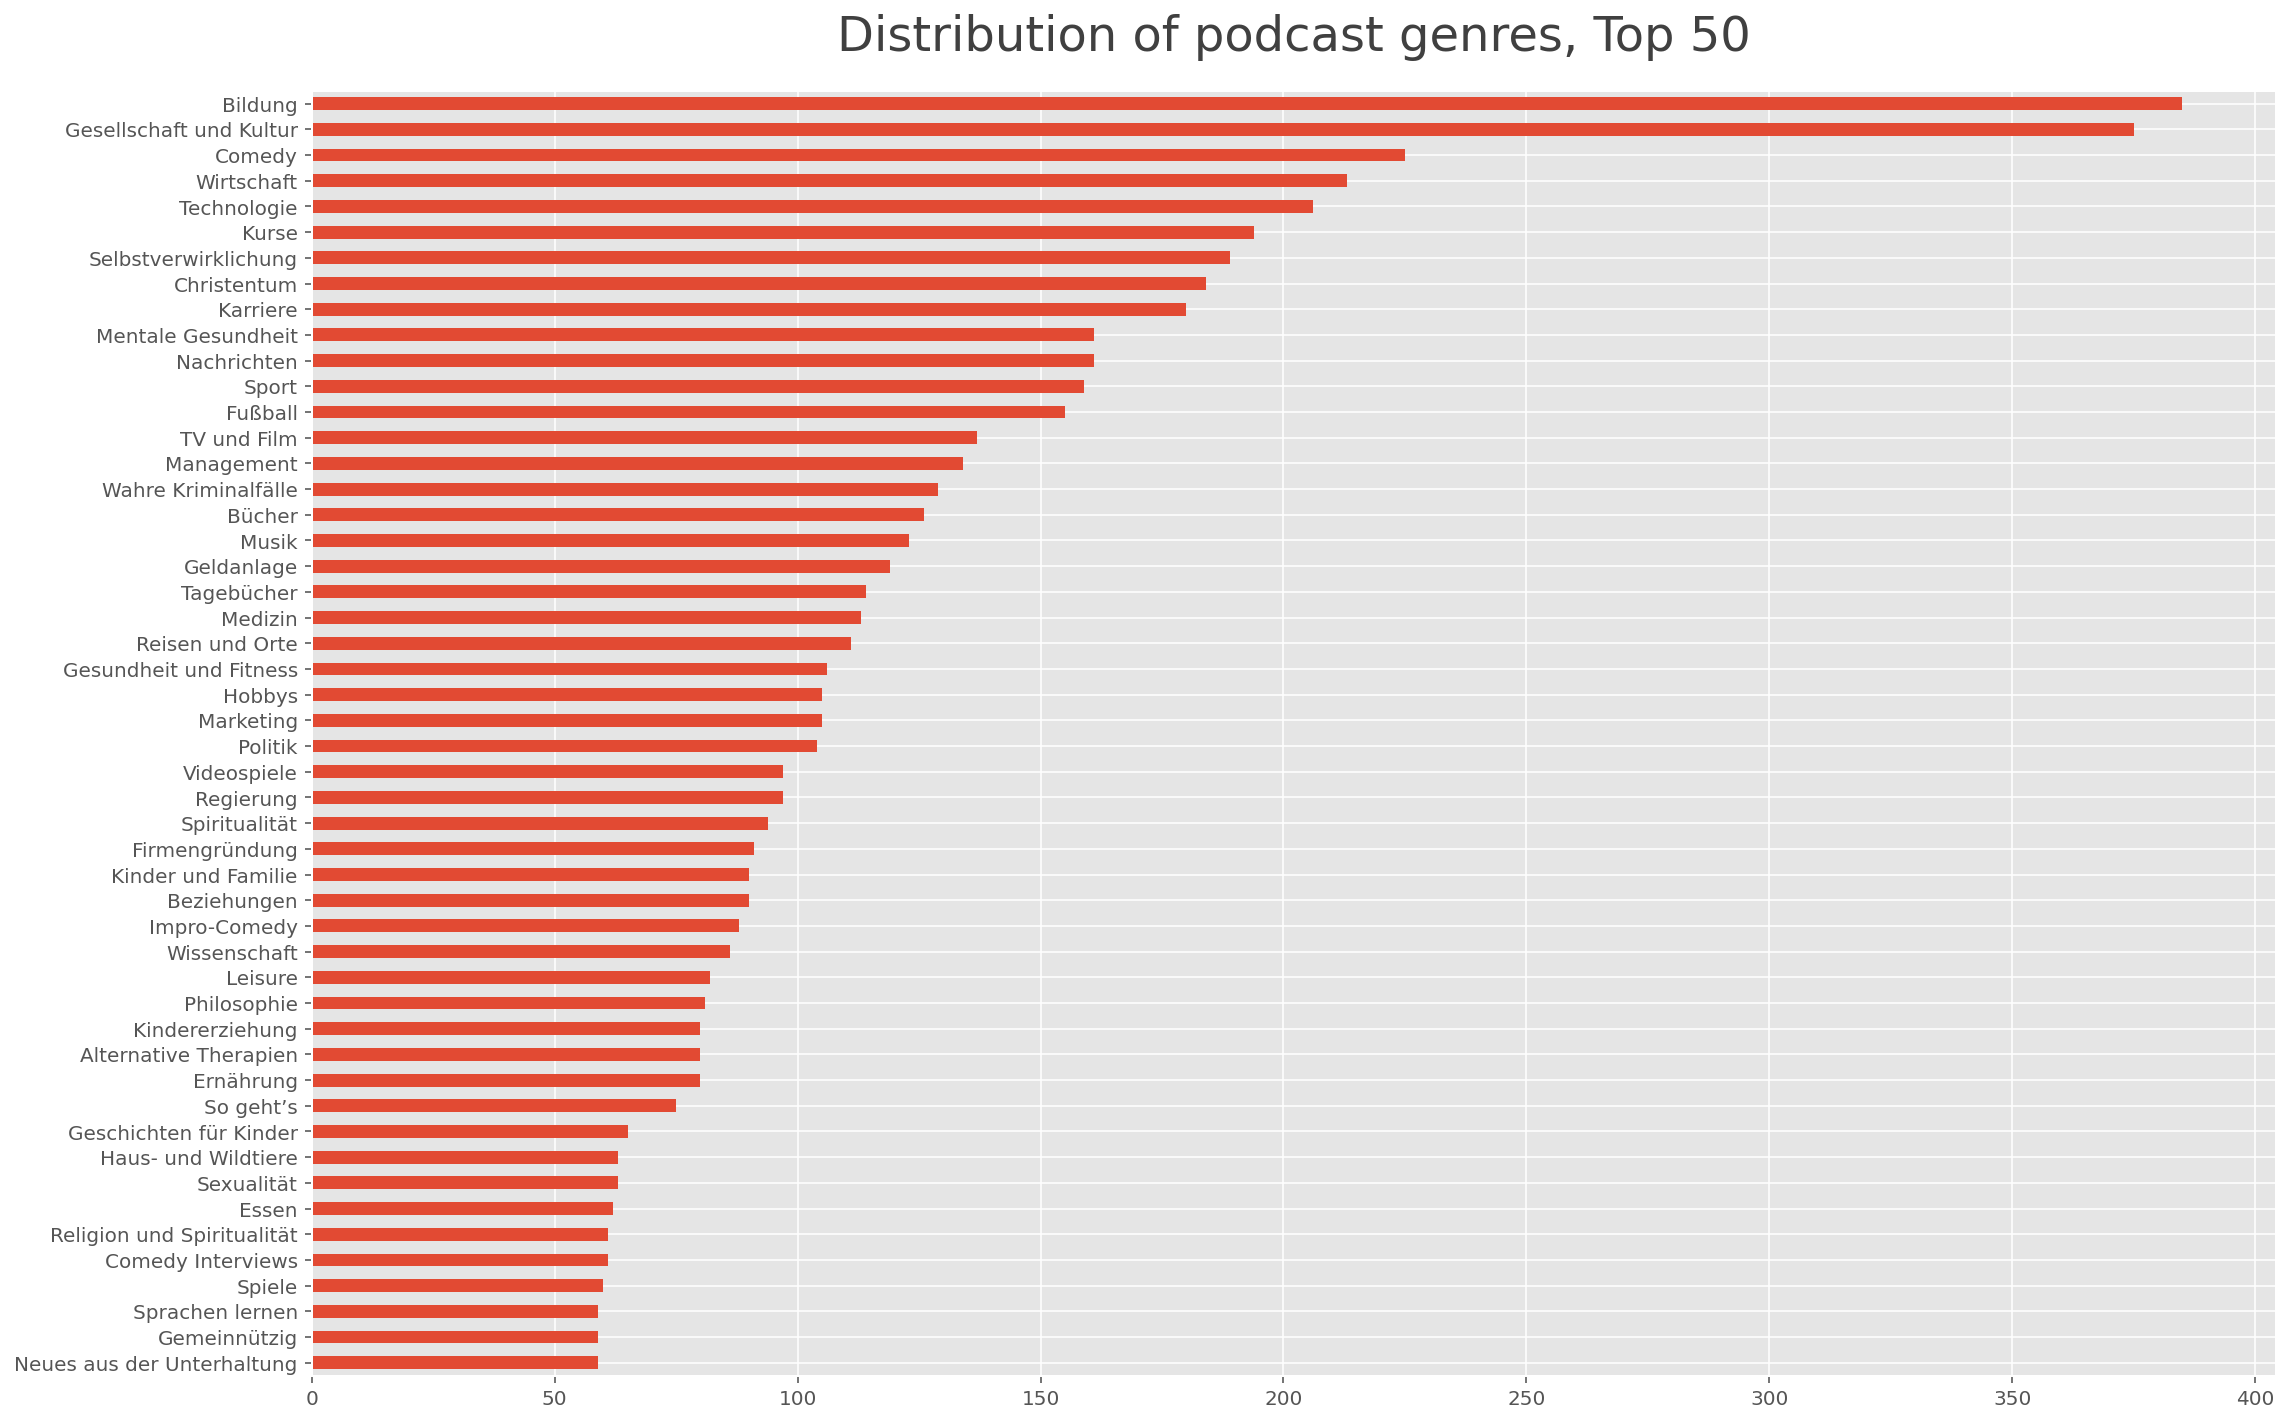

In [25]:
print(f"There are {df.primary_genre.nunique()} unique *primary* genres.")
print()

top_n = 10
print(f"The top {top_n} primary genres are:")
tmp = df.primary_genre.value_counts(dropna=False)
display(tmp[:top_n])
print()

tmp.sort_values(ascending=True, inplace=True)

top_n = 50
fig, ax = plt.subplots(figsize=(16,10))
tmp[-top_n:].plot.barh(ax=ax)
plt.xticks(rotation=0)
plt.title(f"Distribution of podcast genres, Top {top_n}", size=TITLE_SIZE, pad=TITLE_PAD)
plt.tight_layout()
plt.show()

- Feature `genres` contains all genres a podcast belongs to. 
- Plotting their count I observe a more balanced distribution. `Bildung` and `Gesellschaft & Kultur` are still dominant, closely followed by `Wirtschaft` and `Gesundheit und Fitness`.
- Genre `Podcast` is redundant since – well – all podcasts are podcasts...

There are around 110 unique *general* genres.

The 10 most common tags are:


[('Podcasts', 7602),
 ('Bildung', 1377),
 ('Gesellschaft und Kultur', 1246),
 ('Wirtschaft', 1094),
 ('Gesundheit und Fitness', 904),
 ('Nachrichten', 723),
 ('Leisure', 631),
 ('Sport', 595),
 ('Kunst', 515),
 ('Comedy', 502)]

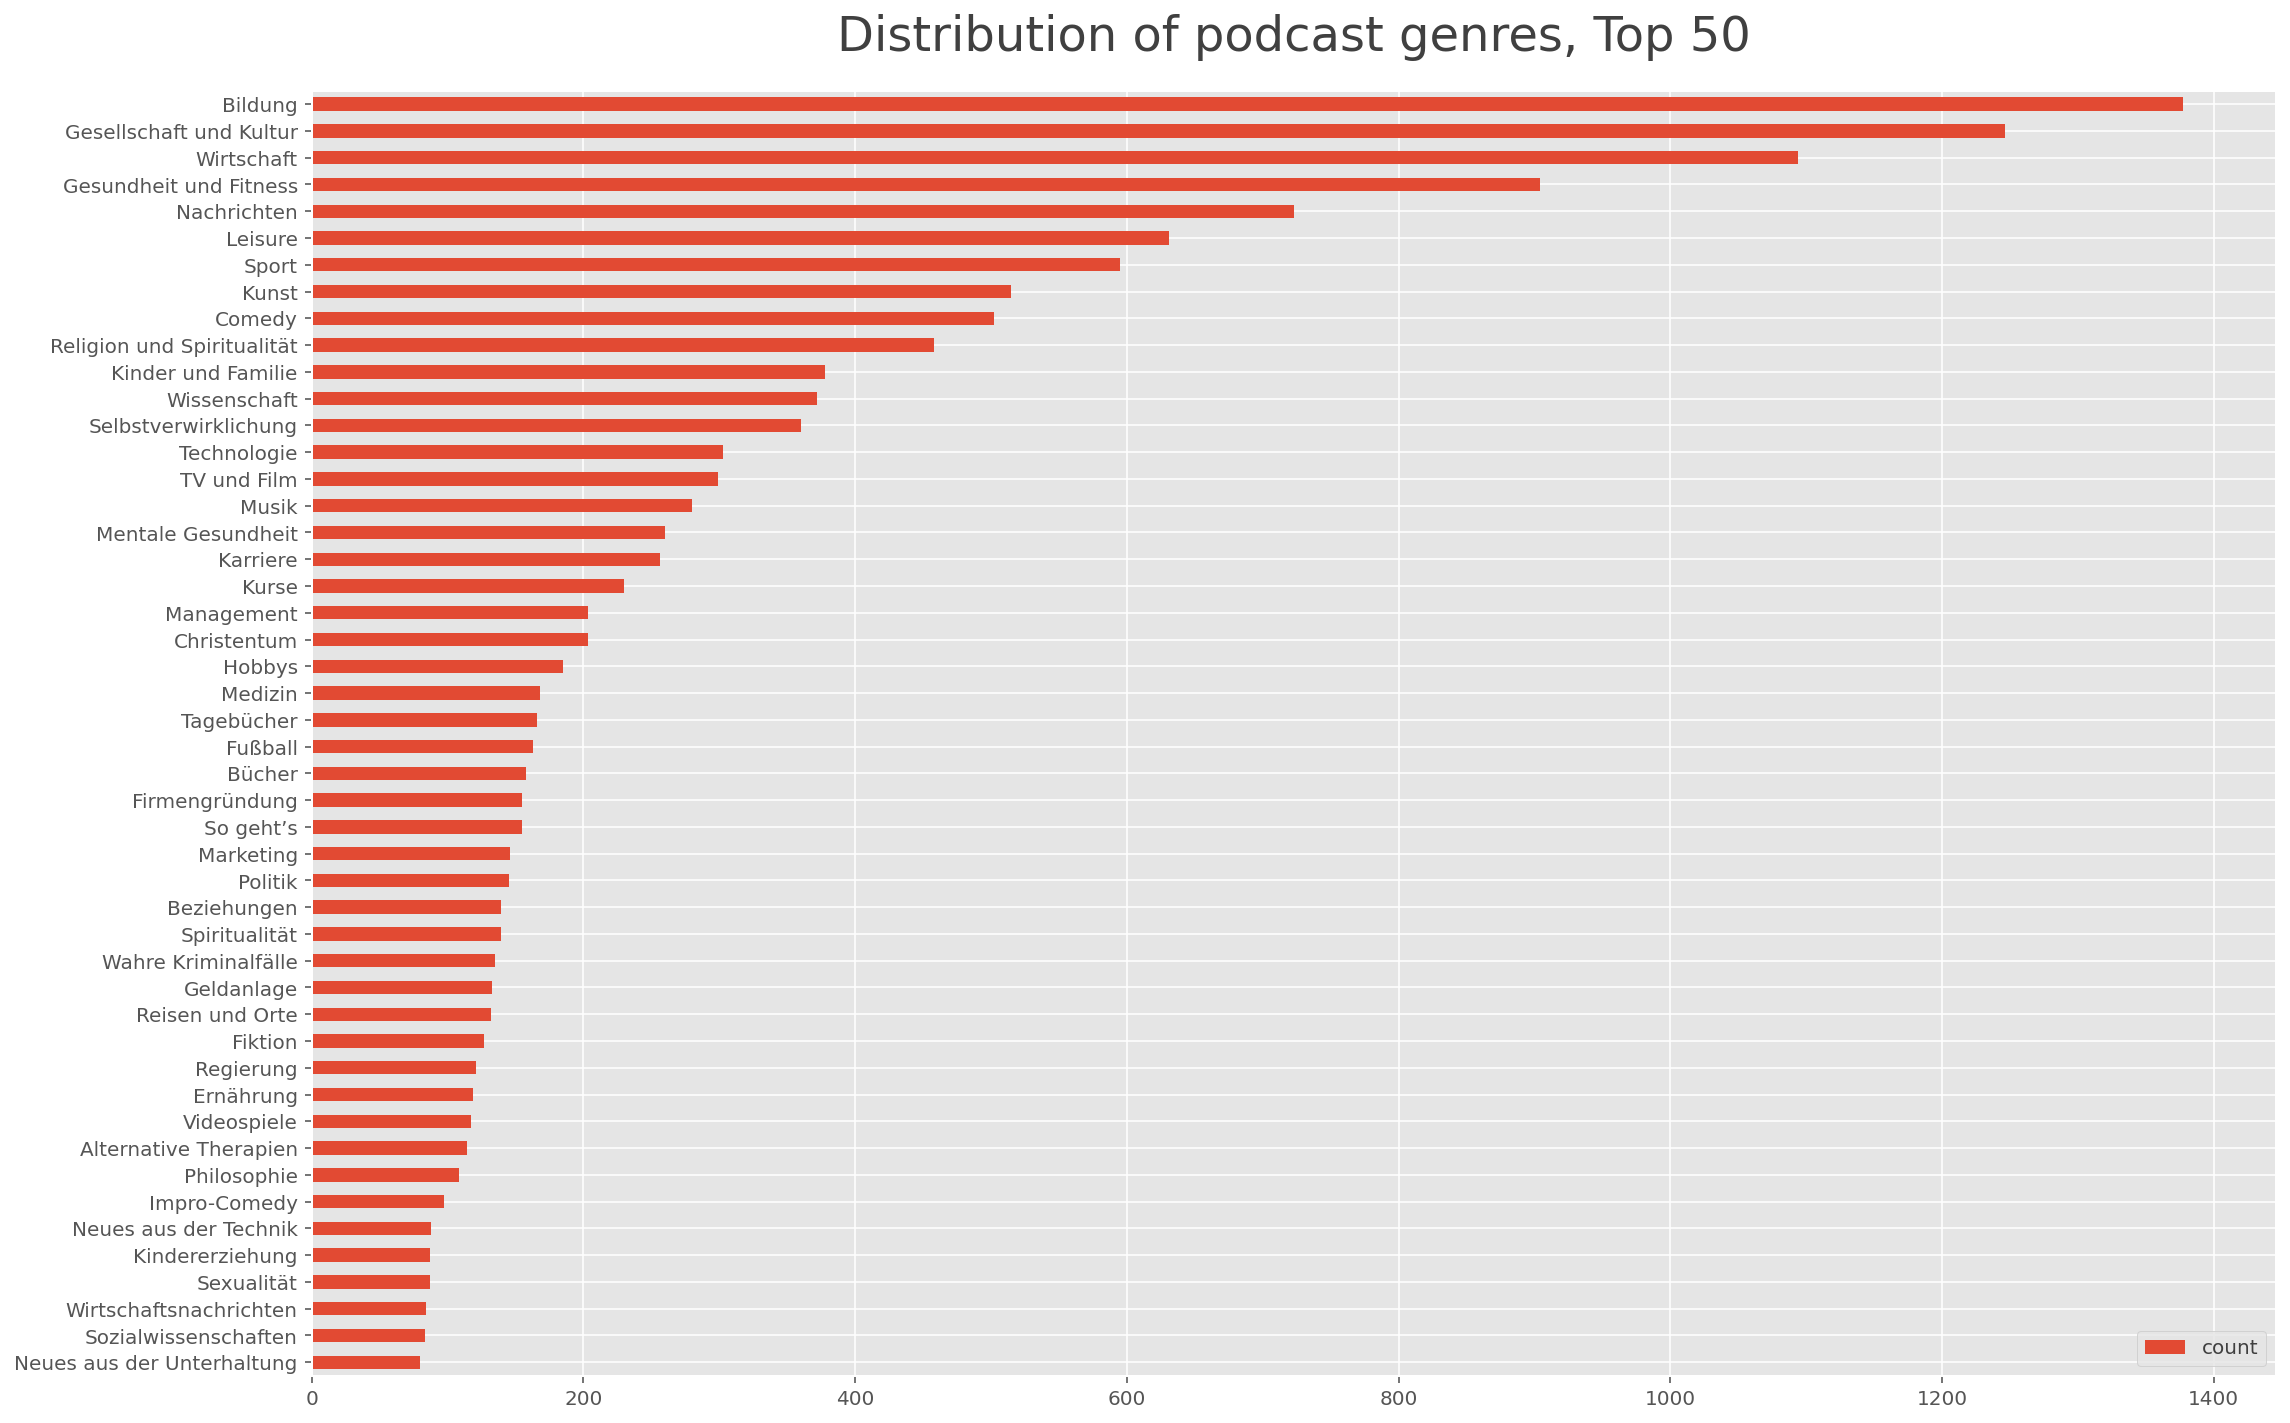

In [26]:
all_genres = []

for genre_list in df.dropna(subset=["genres"]).genres.values:
     all_genres.extend(genre_list)

genre_counter = Counter(all_genres)   

all_genres = [x.lower() for x in all_genres]
all_genres = sorted(set(all_genres))
print(f"There are around {len(all_genres):,.0f} unique *general* genres.")
print()

top_n = 10
print(f"The {top_n} most common tags are:")
display(genre_counter.most_common(top_n))
print()

tmp = pd.DataFrame(genre_counter, index=[0]).T.reset_index()
tmp.columns = ["genre", "count"]
tmp.sort_values("count", inplace=True, ascending=True)
tmp.reset_index(drop=True, inplace=True)

top_n = 50
fig, ax = plt.subplots(figsize=(16,10))
tmp = tmp[-top_n+1:-1]
tmp.plot.barh(ax=ax)
plt.xticks(rotation=0)
plt.yticks(ticks=range(len(tmp)), labels=tmp.genre)
plt.title(f"Distribution of podcast genres, Top {top_n}", size=TITLE_SIZE, pad=TITLE_PAD)
plt.tight_layout()
plt.show()

Among the podcasts that were top listed or scraped from the charts genres like `Wirtschaft`, `Gesundheit und Fitness`, `Gesellschaft und Kultur` and `Sport` rank highest.

In [27]:
display(df.toplist_top_genre.value_counts())

Wirtschaft                    400
Gesundheit und Fitness        372
Gesellschaft und Kultur       312
Sport                         295
Freizeit                      275
Nachrichten                   219
Kinder und Familie            213
Bildung                       211
Kunst                         210
Comedy                        194
Religion und Spiritualität    189
Wissenschaft                  132
TV und Film                   126
Musik                         109
Technologie                    55
Regierung                      49
Wahre Kriminalfälle            37
Geschichte                     29
Fiktion                        29
Name: toplist_top_genre, dtype: int64

In [28]:
display(df.chartable_genre.value_counts())

All Podcasts               92
Sports                     68
Business                   67
Society & Culture          66
Kids & Family              66
Leisure                    64
TV & Film                  60
News                       59
Science                    58
Religion & Spirituality    57
Comedy                     56
Health & Fitness           54
Education                  54
True Crime                 53
Arts                       49
Fiction                    47
Technology                 46
Government                 40
Music                      40
Name: chartable_genre, dtype: int64

### Observations from `generator`

- The `generator` is the service or software that creates an RSS feed from content. 
- Most of these services publish podcasts automatically to various platforms like iTunes, Spotify, Amazon, Google and more.
- The top generators in our data are [Podigee](https://www.podigee.com/en/), [Anchor](https://anchor.fm/), [podcaster.de](https://www.podcaster.de/) and [Podlove](https://podlove.org/). 
- Many podcasts are published with Wordpress (plugins).

In [29]:
display(df.generator.apply(lambda x: x.split(" ")[0]
                   .split("/?")[0]
                   .replace("http://", "")
                   .replace("https://", "")
                   .replace(".de", "")
                   .replace(".com", "")
                   .replace(".org", "")
                   .replace("/", "")
                   .lower() if x is not None else None).value_counts()[:10])

podigee        1905
anchor         1270
podcaster       662
wordpress       389
podlove         372
libsyn          341
podhost         158
manual          139
wdr-podcast     130
letscast.fm      97
Name: generator, dtype: int64

### Observations from `itunes_type`

- **~72% of podcasts in our data are episodic rather than serial.**

71.89% of podcasts are episodic.



episodic    5465
NaN         1776
serial       361
Name: itunes_type, dtype: int64

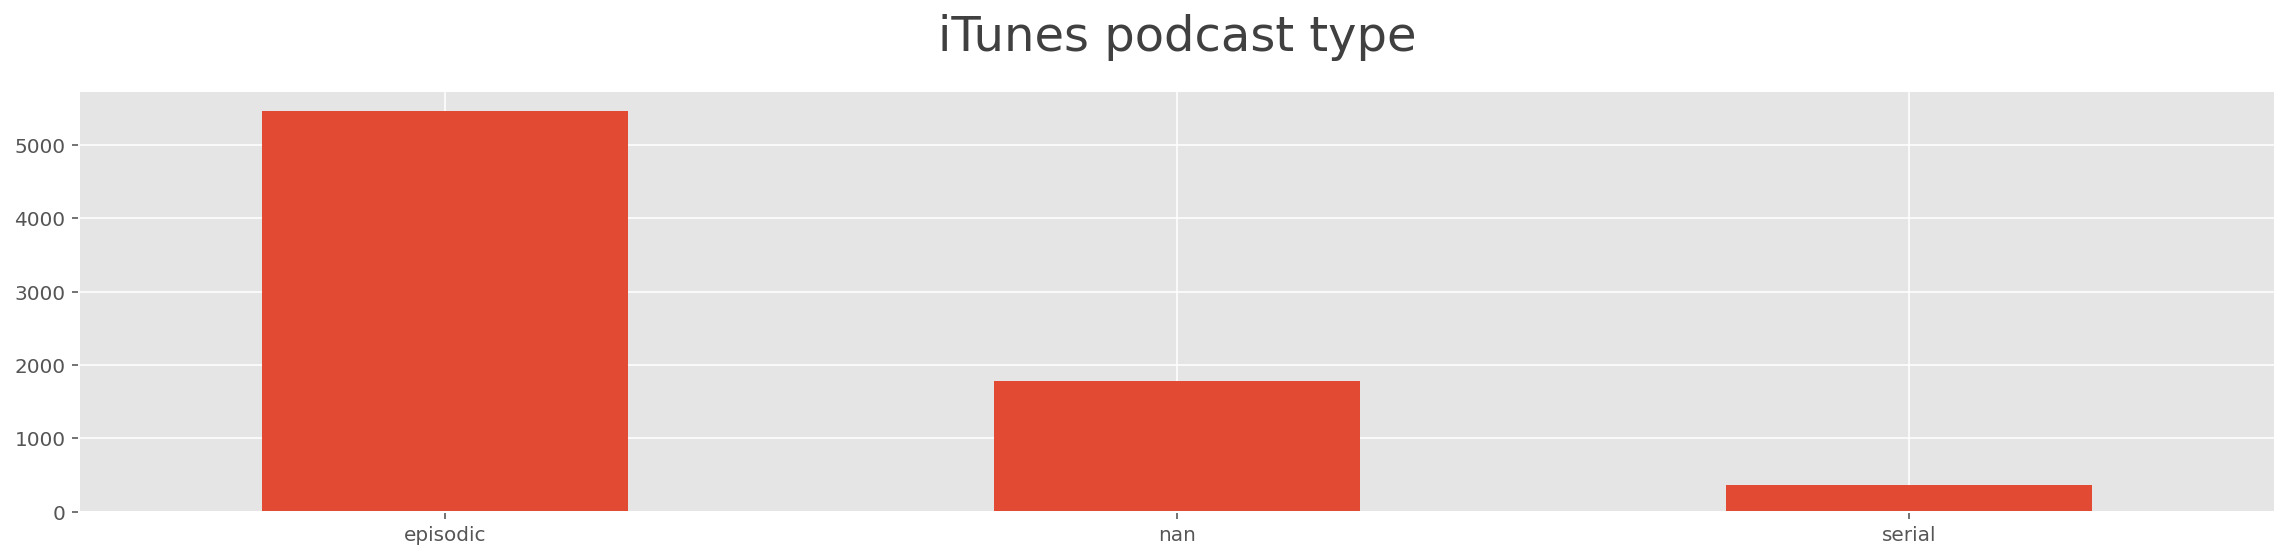

In [30]:
tmp = df.itunes_type.value_counts(dropna=False)
print(f"{100 / tmp.sum() * tmp['episodic']:.2f}% of podcasts are episodic.")
print()
display(tmp)

fig, ax = plt.subplots(figsize=(16,4))
tmp.plot.bar(ax=ax)
plt.xticks(rotation=0)
plt.title("iTunes podcast type", size=TITLE_SIZE, pad=TITLE_PAD)
plt.tight_layout()
plt.show()

### Observations from `explicit`

- **By far the mayority of podcast in our data is labeled as having explicit content.**
- The RSS tag `explicit` is parental advisory information. Explicit content is [defined here by Apple](https://podcasters.apple.com/support/891-content-and-subscription-guidelines):

> 1.2. Explicit Content. Creators must flag individual episodes with the “Explicit” tag if they contain explicit content (for example, profanity or content that may not be suitable for children).

Apple gives [the following additional information for creators](https://help.apple.com/itc/podcasts_connect/#/itcb54353390):

> The explicit value can be one of the following:
> - `True` – If you specify true, indicating the presence of explicit content, Apple Podcasts displays an Explicit parental advisory graphic for your podcast. Podcasts containing explicit material aren’t available in some Apple Podcasts territories.
> - `False` – If you specify false, indicating that your podcast doesn’t contain explicit language or adult content, Apple Podcasts displays a Clean parental advisory graphic for your podcast.

92.44% of podcasts are labeled as having explicit content.



True     7027
False     575
Name: explicit, dtype: int64

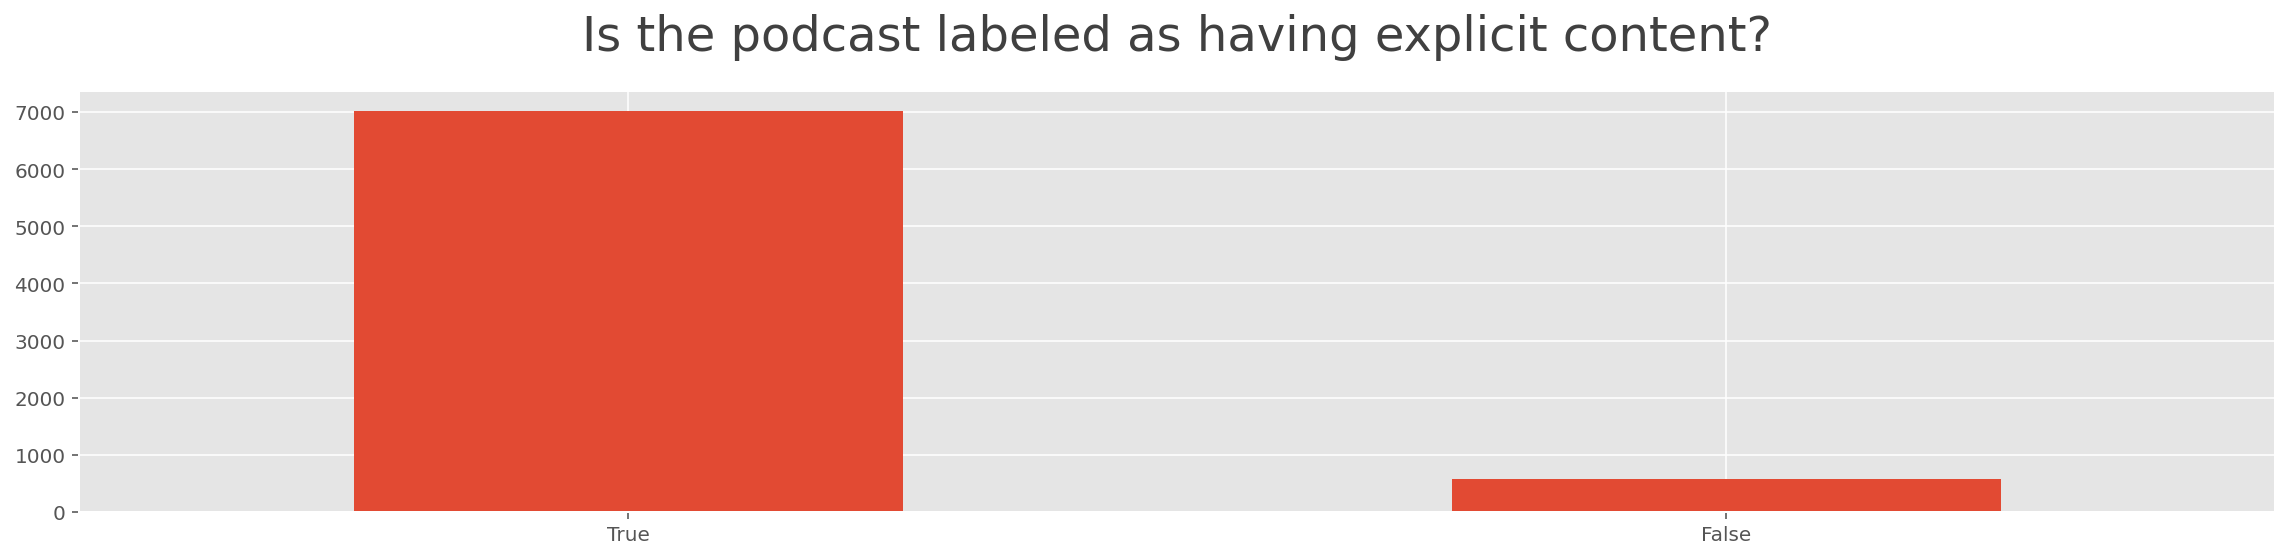

In [31]:
tmp = df.explicit.value_counts(dropna=False)
print(f"{100 / tmp.sum() * tmp[True]:.2f}% of podcasts are labeled as having explicit content.")
print()
display(tmp)

fig, ax = plt.subplots(figsize=(16,4))
tmp.plot.bar(ax=ax)
plt.xticks(rotation=0)
plt.title("Is the podcast labeled as having explicit content?", size=TITLE_SIZE, pad=TITLE_PAD)
plt.tight_layout()
plt.show()

### Observations from `releaseDate`

- Unfortunately I can't find any official information what exactly the podcast release date means. By checking some samples manually in Apple's podcast app I see that **the release date seems to indicate the last update, e.g. the release date of the most recent episode.**
- **By far the most samples in our data have a release year of 2021.** 
- **Almost 1k of podcast had their last episode published before 2019. We can remove these** and just concentrate on podcasts that are more up-to-date.
- The one sample with release year 2022 has to be an error (I acquired the data in December 2021).

967 podcasts (12.72% of total) had their last update before 2019 and likely aren't maintained anymore.



2005       4
2006      29
2007      33
2008      37
2009      44
2010      66
2011      73
2012      60
2013      60
2014      78
2015      98
2016     114
2017     120
2018     151
2019     328
2020     886
2021    5420
2022       1
Name: releaseDate, dtype: int64

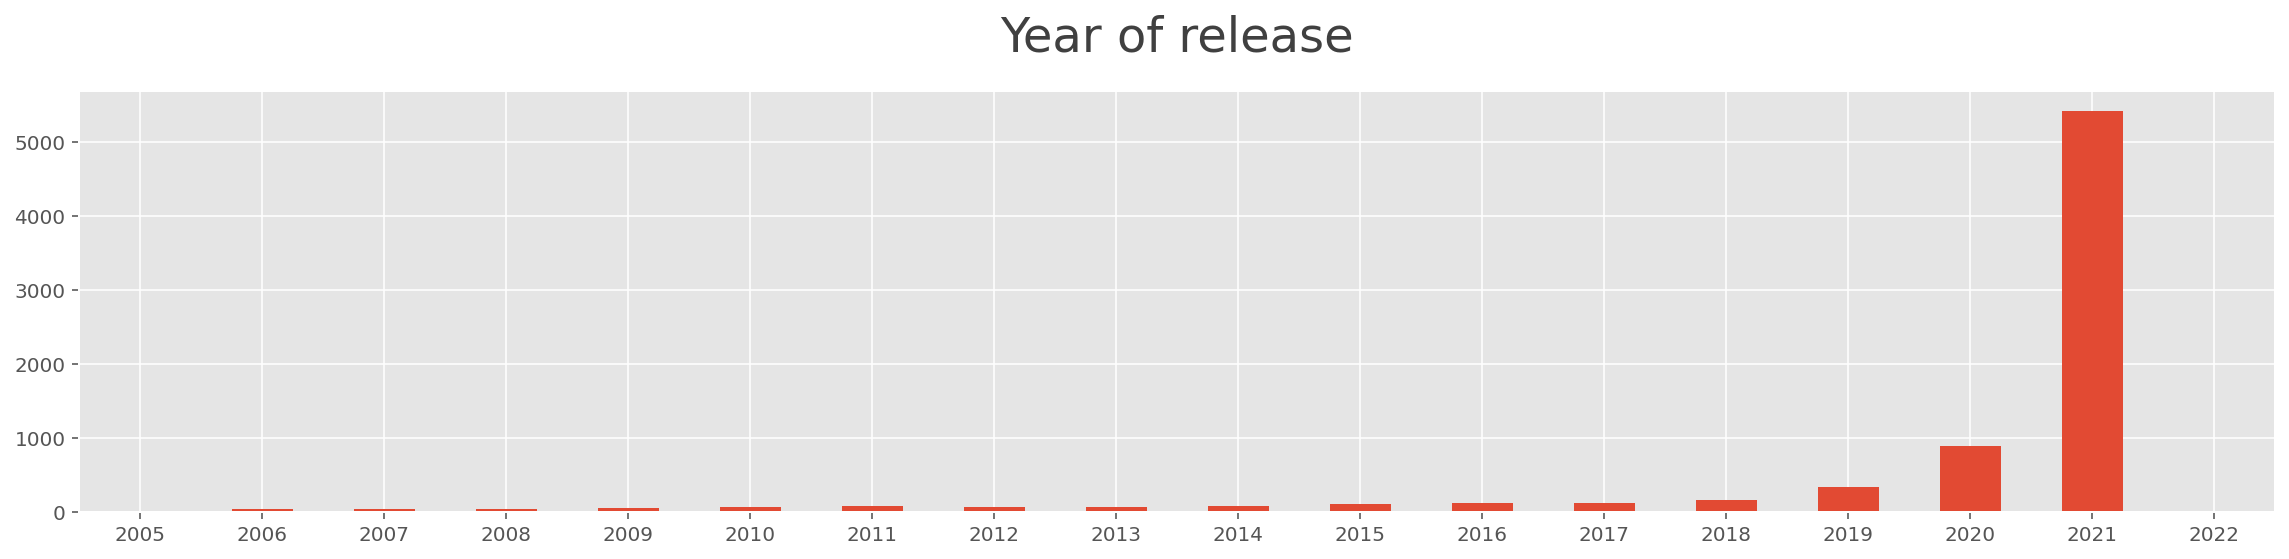

In [32]:
before_year = 2019
tmp = df.releaseDate.dt.year.value_counts(dropna=False).sort_index()
before_year_count = tmp[tmp.index<before_year].sum()
before_year_perc = 100 / tmp.sum() * before_year_count
print(f"{before_year_count} podcasts ({before_year_perc:.2f}% of total) had their last update before {before_year} and likely aren't maintained anymore.")
print()

display(tmp)
print()

fig, ax = plt.subplots(figsize=(16,4))
df.releaseDate.dt.year.value_counts().sort_index().plot.bar(ax=ax)
plt.xticks(rotation=0)
plt.title("Year of release", size=TITLE_SIZE, pad=TITLE_PAD)
plt.tight_layout()
plt.show()

In [33]:
# Display the one podcast with release date year 2022
display(df[df.releaseDate.dt.year==2022])

,trackId,artistName,ep_authors,title,ep_titles,ep_itunes_titles,subtitle,ep_subtitles,summary,ep_summaries,...,toplist_genre_id,generator,itunes_type,explicit,releaseDate,trackCount,feedUrl,artworkUrl600,from_chartable,not_longtail
1183,961587581,Lübbe Audio,"[Dietmar Wunder, Lübbe Audio]",Geisterjäger John Sinclair,"[DAS ENDE - Verneigung vor den Verblichenen, D...","[DAS ENDE - Verneigung vor den Verblichenen, D...",Der offizielle John Sinclair Podcast,[DER NEUE JOHN SINCLAIR-PODCAST\n In der erste...,Der offizielle John Sinclair Podcast,[Adventszeit bedeutet für viele Menschen Shopp...,...,None,Podigee (https://podigee.com),episodic,True,2022-03-17 23:00:00+00:00,69,https://podcast78edc2.podigee.io/feed/mp3,https://is1-ssl.mzstatic.com/image/thumb/Podca...,1.0,1


### Observations from `trackCount`

- **The track count for available episodes ranges from 1 to 2025**.
- The distribution is not normal, but very skewed. 
- **The median is 28 available episodes**.
- Several of the podcasts with the highest track count come from public service media (BR, SWR), publishers like ZEIT, DER SPIEGEL and BILD or are related to religion & spirituality.

count    7602
mean       64
std       118
min         1
25%        10
50%        28
75%        74
max      2025
Name: trackCount, dtype: int64

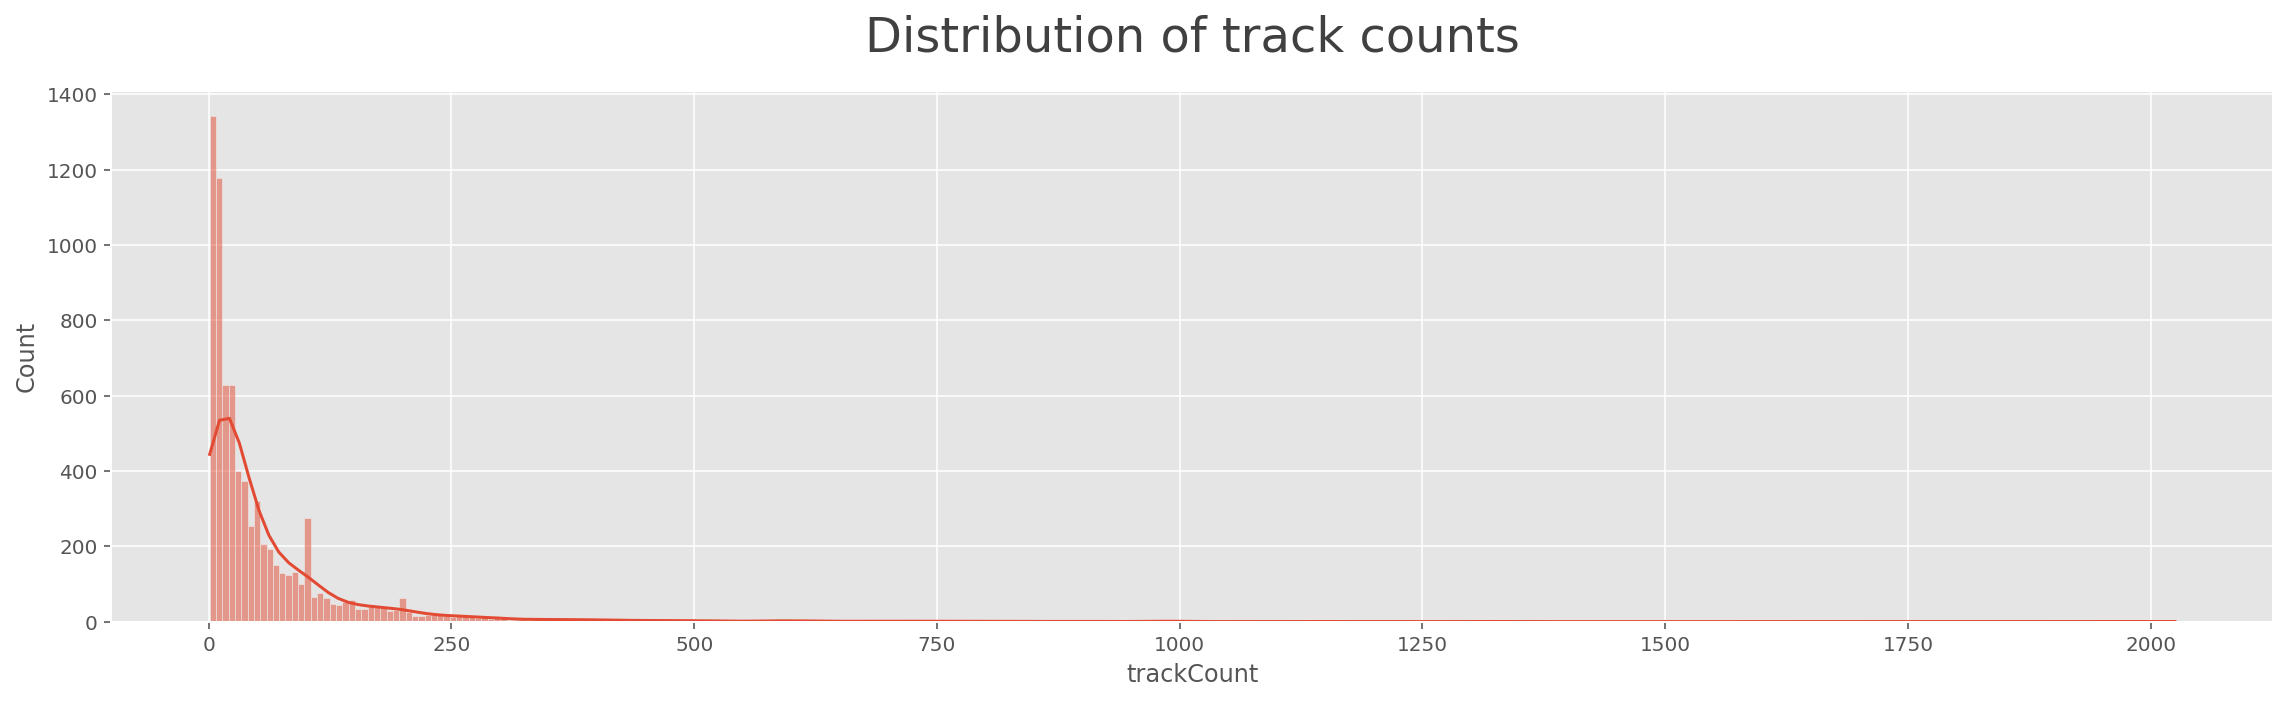

In [34]:
display(df.trackCount.describe().astype(int))

fig, ax = plt.subplots(figsize=(16,5))
sns.histplot(df.trackCount, kde=True,  
             ax=ax, color=DEFAULT_COLORS[0], 
             # log_scale=True
            )
plt.xticks(rotation=0)
plt.title("Distribution of track counts", size=TITLE_SIZE, pad=TITLE_PAD)
plt.tight_layout()
plt.show()

In [35]:
# Printing the podcasts with very high track counts.
cols = ["artistName", "title", "primary_genre", "trackCount"]
display(df[df.trackCount>1_000][cols].sort_values("trackCount", ascending=False))

,artistName,title,primary_genre,trackCount
47,Bayerischer Rundfunk,Klassik aktuell,Musik,2025
199,Bayerischer Rundfunk,radioWissen,Wissenschaft,2000
344,radio horeb,Credo - Der Glaube der Kirche,Religion und Spiritualität,1998
26,SWR,SWR2 Wissen,Wissenschaft,1776
14,SWR,SWR2 Wissen,Wissenschaft,1775
4693,oe24.at,Fellner! LIVE,Nachrichten des Tages,1692
2036,ZEIT ONLINE,Was jetzt?,Nachrichten,1502
3693,DER SPIEGEL,Die Lage,Nachrichten,1459
315,Verlag C. H. Beck,NJW Podcast,Nachrichten,1326
462,DOMRADIO.DE,Gespräch zum Evangelium,Christentum,1310


### Observations from `feedUrl`

- The feed URLs do not reveal any salient information for our task of improving search and discovery. 

In [36]:
display(df.feedUrl.apply(lambda x: x.split("://")[1].split("/")[0]).value_counts()[:10])

anchor.fm                      1264
feeds.soundcloud.com            270
feeds.video.uni-erlangen.de     205
feeds.feedburner.com            143
www1.wdr.de                     122
feeds.buzzsprout.com            116
www.ndr.de                      111
letscast.fm                      93
feed.podbean.com                 71
rss.art19.com                    70
Name: feedUrl, dtype: int64

### Observations from `artworkUrl600`

- The podcast artwork is hosted on 5 endpoints of Apple's CDN (mzstatic.com).
- Retrieving the actual imagery and performing visual analytics like object recognition or more advance embeddings with e.g., [CLIP](https://openai.com/blog/clip/) could provide useful.  

In [37]:
display(df.artworkUrl600.apply(lambda x: x.split("://")[1].split("/")[0]).value_counts())

is4-ssl.mzstatic.com    1602
is5-ssl.mzstatic.com    1531
is2-ssl.mzstatic.com    1517
is1-ssl.mzstatic.com    1496
is3-ssl.mzstatic.com    1456
Name: artworkUrl600, dtype: int64

### Observations from `from_chartable`

- All podcasts with values 1 and higher are podcasts that were listed in iTunes' actual Podcast Charts (Dez. 2021).
- A value higher than 1 indicates how many times the podcast was found in the charts. 

In [38]:
display(df.from_chartable.value_counts().sort_index())

0.0    6506
1.0     896
2.0     159
3.0      39
4.0       1
5.0       1
Name: from_chartable, dtype: int64

### Observations from `not_longtail`

- A value of 1 or higher means the podcast was top listed or in the iTunes charts.
- The value indicates how many times the podcast was found in a chart or a top list. 
- We roughly have a 60/40 ratio between popular top list/chart podcasts and long tail podcasts.

In [39]:
top_podcasts_perc = 100 / len(df) * df[df.not_longtail>0].shape[0]
print(f"{top_podcasts_perc:.2f}% of podcasts in the data set were either top listed by iTunes or ranked in the iTunes Charts.")
print()
display(df.not_longtail.value_counts().sort_index())

59.88% of podcasts in the data set were either top listed by iTunes or ranked in the iTunes Charts.



0    3050
1     896
2    2552
3     437
4     420
5     156
6      26
7      54
8       9
9       2
Name: not_longtail, dtype: int64

# Conclusions

- **The gathered data appears to be sufficient for the task**. We have a lot of textual data that we can process. 
- In addition to the textual content we collected links to the audio files for 80k episodes that we could analyze on the audio level, e.g., to create features of the tonality and structure of the podcast.
- There is **promising and salient information in many features**, especially in titles, subtitles, summaries and «contents».
- Data is missing for several features. However, **missing values mainly appear to be relevant for summaries and episode tags**.
- The textual data isn't clean: It contains HTML tags, links, control characters, emoji and much more noise.
- **The data contains promotional content and sponsor messages too.** This can be problematic since it brings in key words and entities that might have nothing to do with the actual content of the podcast and are hard to filter out at the same time.


- The mean/median of podcast per author is around 1. We have a wide diversity of offerings to work with. 
- Some publishers have larger collections in the data set, e.g. WDR with 103 unique podcasts.
- There is a **wide range of available episode counts between 1 epsiode to 2k**. The median is 28.
- In general we have more textual information if many episodes are available.
- I see a **wide range of text lengths**, e.g. in summaries.
- There is **salient information in tag features** too. At first glance I could count 13k unique podcast tags and 230k episode tags. Especially the latter will need some additional cleaning. 
- The **podcasts aren't normally distributed in terms of genres**. Genres `Bildung`, `Gesellschaft und Kultur` dominate, followed by genres like `Comedy` and `Wirtschaft`.


- **~13% of podcasts had their last update 3 years ago or earlier** and need to be removed.
- **~60% of podcasts were found in charts or top lists.** ~40% can be considered as less popular long tail offerings.
- **~72% of podcasts are episodic** rather than serial. 
- **~92% of podcasts are labeled as having explicit content.**